In [24]:
import numpy as np
import matplotlib.pyplot as plt

---
# Image Gradients

Function takes a grayscale image as input and returns two arrays the same size as the image, the first of which contains the magnitude of the image gradient at each pixel and the second containing the orientation.

NOTE: The gradient orientation values return should range in (-pi/2,+pi/2) where a horizontal edge (vertical gradient) is -pi/2 and the angle increases as the edge rotates clockwise in the image.

In [25]:
from scipy import ndimage

def mygradient(image):
    """
    This function takes a grayscale image and returns two arrays of the
    same size, one containing the magnitude of the gradient, the second
    containing the orientation of the gradient.
    
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    Returns
    -------
    mag : 2D float array of shape HxW
        gradient magnitudes
        
    ori : 2Dfloat array of shape HxW
        gradient orientations in radians
    """
    
    weights_x = [[0, 0, 0],
                 [0, 1, -1],
                 [0, 0, 0]]
    
    weights_y = [[0, 0, 0],
                 [0, 1, 0],
                 [0, -1, 0]]
    
    image = ndimage.gaussian_filter(image, sigma=0.15)
    
    x_derivatives = ndimage.correlate(image, weights_x, mode="nearest")
    y_derivatives = ndimage.correlate(image, weights_y, mode="nearest")
    
    mag = np.zeros((image.shape[0], image.shape[1]))
    ori = np.zeros((image.shape[0], image.shape[1]))
    
    mag = np.sqrt(np.square(x_derivatives)+np.square(y_derivatives))
    ori = np.arctan2(y_derivatives, x_derivatives)
    
    ori[np.where(ori > np.pi/2)] -= np.pi
    ori[np.where(ori < -np.pi/2)] += np.pi
    
    return (mag,ori)

---

# Histograms of Gradient Orientations

A function computes gradient orientation histograms over each 8x8 block of pixels in an image. The function should bin the orientation into 9 equal sized bins between -pi/2 and pi/2. The input of this function will be an image of size HxW. The output should be a three-dimensional array ***ohist*** whose size is (H/8)x(W/8)x9 where ***ohist[i,j,k]*** contains the count of how many edges of orientation k fell in block (i,j). If the input image dimensions are not a multiple of 8, we will use ***np.pad*** with the ***mode=edge*** option to pad the width and height up to the nearest integer multiple of 8.

To determine if a pixel is an edge, we need to choose some threshold (using a threshold that is 10% of the maximum gradient magnitude in the image). Since each 8x8 block will contain a different number of edges, we should normalize the resulting histogram for each block to sum to 1 at every location.

In [26]:
import skimage as ski 

def hog(image,bsize=8,norient=9):
    
    """
    This function takes a grayscale image and returns a 3D array
    containing the histogram of gradient orientations descriptor (HOG)
    We follow the convention that the histogram covers gradients starting
    with the first bin at -pi/2 and the last bin ending at pi/2.
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9
        
    Returns
    -------
    ohist : 3D float array of shape (H/bsize,W/bsize,norient)
        edge orientation histogram
        
    """   
    # determine the size of the HOG descriptor
    (h,w) = image.shape
    h2 = int(np.ceil(h/float(bsize)))
    w2 = int(np.ceil(w/float(bsize)))
    ohist = np.zeros((h2,w2,norient))
    
    # pad the input image on right and bottom as needed so that it 
    # is a multiple of bsize
    ph = 7-((h+7)%8)
    pw = 7-((w+7)%8)
    pw = (int(pw/2), pw-int(pw/2)) #amounts to pad on left and right side
    ph = (int(ph/2), ph-int(ph/2)) #amounts to pad on bottom and top side
    image = np.pad(image,(ph,pw),'edge')
        
    # make sure we did the padding correctly
    assert(image.shape==(h2*bsize,w2*bsize))
    
    # compute image gradients
    (mag,ori) = mygradient(image)
    
    # choose a threshold which is 10% of the maximum gradient magnitude in the image
    thresh = 0.1*np.amax(mag)
    
    # separate out pixels into orientation channels, dividing the range of orientations
    # [-pi/2,pi/2] into norient equal sized bins and count how many fall in each block    
    binEdges = np.linspace(-np.pi/2, np.pi/2, norient+1);
    
    # as a sanity check, make sure every pixel gets assigned to at most 1 bin.
    bincount = np.zeros((h2*bsize,w2*bsize))
        
    for i in range(norient):
        #create a binary image containing 1s for pixels at the ith 
        #orientation where the magnitude is above the threshold.
        
        pos = np.where((ori >= binEdges[i]) & (ori <= binEdges[i+1]) & (mag > thresh))
        
        B = np.zeros(image.shape)
        B[pos] = 1
    
        # sanity check: record which pixels have been selected at this orientation
        bincount = bincount + B
        
        # pull out non-overlapping bsize x bsize blocks
        chblock = ski.util.view_as_windows(B,(bsize,bsize),step=bsize)
            
        # sum up the count for each block and store the results
        for k in range(chblock.shape[0]):
            for j in range(chblock.shape[1]):
                ohist[k,j,i] = np.count_nonzero(chblock[k,j])
        
    # each pixel should have only selected at most once
    assert(np.all(bincount<=1))

    # lastly, normalize the histogram so that the sum along the orientation dimension is 1
    # note: don't divide by 0! If there are no edges in a block (i.e. the sum of counts
    # is 0) then your code should leave all the values as zero.
    total = np.zeros((ohist.shape[0], ohist.shape[1]))
    
    for i in range(ohist.shape[2]):
        total += ohist[:,:,i]
    
    for i in range(ohist.shape[2]):
        ohist[:,:,i] = np.divide(ohist[:,:,i], total, out=np.zeros_like(ohist[:,:,i]), where=total!=0)
  
    assert(ohist.shape==(h2,w2,norient))
        
    return ohist

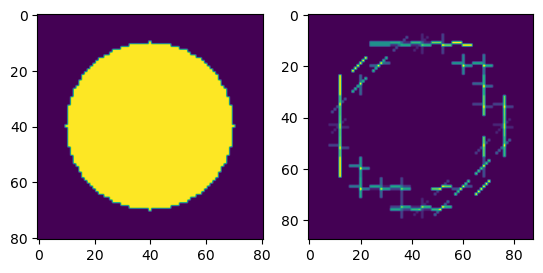

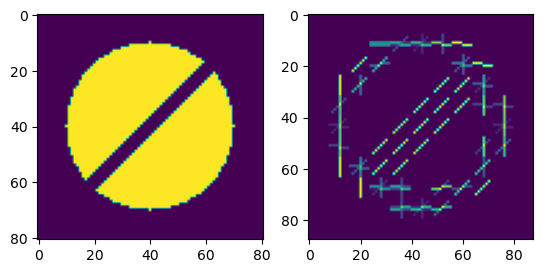

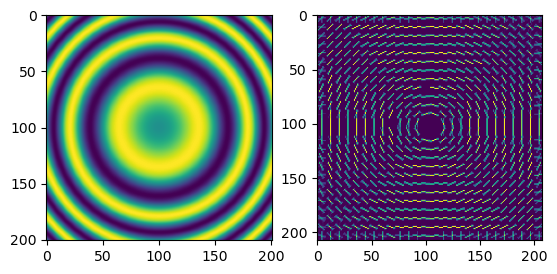

In [27]:
from hogvis import hogvis

# generate a simple test image... a 80x80 image
# with a circle of radius 30 in the center
[yy,xx] = np.mgrid[-40:41,-40:41]
im = np.array((xx*xx+yy*yy<=30*30),dtype=float)

# display the image and the output of hogvis
hist = hog(im)
hogim = hogvis(hist)

plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hogim)
plt.show()

# two other synthetic test images to experiment with
[yy,xx] = np.mgrid[-40:41,-40:41]
im = np.array((xx*xx+yy*yy<=30*30),dtype=float)
im[np.abs(xx+yy)<=3] = 0

hist = hog(im)
hogim = hogvis(hist)

plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hogim)
plt.show()

[yy,xx] = np.mgrid[-100:101,-100:101]
im = np.array(np.sin((xx*xx+yy*yy)/800),dtype=float)

hist = hog(im)
hogim = hogvis(hist)

plt.subplot(1,2,1)
plt.imshow(im)
plt.subplot(1,2,2)
plt.imshow(hogim)
plt.show()

---
# Detection

Write a function that takes a template and an image and returns the top detections found in the image. The function should follow the definition given below.

In the function we should first compute the histogram-of-gradient-orientation feature map for the image, then correlate the template with the feature map. Since the feature map and template are both three dimensional, we will want to filter each orientation separately and then sum up the results to get the final response. If the image of size HxW then this final response map will be of size (H/8)x(W/8).

When constructing the list of top detections, the code should implement non-maxima suppression so that it doesn't return overlapping detections. We can do this by sorting the responses in descending order of their score. Every time we add a detection to the list to return, check to make sure that the location of this detection is not too close to any of the detections already in the output list. You can estimate the overlap by computing the distance between a pair of detections and checking that the distance is greater than say 70% of the width of the template.

In [28]:
from scipy import ndimage

def detect(image,template,ndetect=5,bsize=8,norient=9):
    
    """
    This function takes a grayscale image and a HOG template and
    returns a list of detections where each detection consists
    of a tuple containing the coordinates and score (x,y,score)
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    template : a 3D float array 
        The HOG template we wish to match to the image
        
    ndetect : int
        Maximum number of detections to return

    bsize : int
        The size of the spatial bins in pixels, defaults to 8
        
    norient : int
        The number of orientation histogram bins, defaults to 9
    
    Returns
    -------
    detections : a list of tuples of length ndetect
        Each detection is a tuple (x,y,score)
        
    """   
    
    # norient for the template should match the norient parameter passed in
    assert(template.shape[2]==norient)
    
    fmap = hog(image,bsize=bsize,norient=norient)
    
    # cross-correlate the template with the feature map to get the total response
    resp = np.zeros((fmap.shape[0],fmap.shape[1]))
    for i in range(norient):
        resp = resp + ndimage.correlate(fmap[:,:,i], template[:,:,i])
    
    # sort the values in resp in descending order.
    # val[i] should be ith largest score in resp
    # ind[i] should be the index at which it occurred so that val[i]==resp[ind[i]]
    # 
    flat = -np.sort(-resp.flatten())
    val = list()
    ind = list()
    
    while len(flat) != 0:
        m = max(flat)
        val.append(m)
        p = np.where(resp==m)
        ind.append((int(p[1][0]),int(p[0][0])))
        flat = flat[1:]
        
    # work down the list of responses from high to low, to generate a 
    # list of ndetect top scoring matches which do not overlap
    detcount = 0
    i = 0
    detections = []
    while ((detcount < ndetect) and (i < len(val))):
        # convert 1d index into 2d index
        yb = ind[i][1]
        xb = ind[i][0]
    
        assert(val[i]==resp[yb,xb]) #make sure we did indexing correctly
        
        # covert block index to pixel coordinates based on bsize
        xp = xb*bsize
        yp = yb*bsize
    
        # check if this detection overlaps any detections that we've already added
        # to the list. compare the x,y coordinates of this detection to the x,y 
        # coordinates of the detections already in the list and see if any overlap
        # by checking if the distance between them is less than 70% of the template
        # width/height
    
        counter = 0
        overlap = False
        
        while counter < len(detections):
            a = np.array((detections[counter][0], detections[counter][1]))
            b = np.array((xp, yp))

            if np.linalg.norm(a-b) < 0.7*template.shape[0]*bsize:
                overlap = True
                break
                
            counter += 1
        
        # if the detection doesn't overlap then add it to the list
        if not overlap:
            detcount = detcount + 1
            detections.append((xp,yp,val[i]))
        
        i=i+1
    
    if (len(detections) < ndetect):
        print('WARNING: unable to find ',ndetect,' non-overlapping detections')
    
    return detections

In [29]:
import matplotlib.patches as patches

def plot_detections(image,detections,tsize_pix):
    """
    This is a utility function for visualization that takes an image and
    a list of detections and plots the detections overlayed on the image
    as boxes.
    
    Color of the bounding box is based on the order of the detection in
    the list, fading from green to red.
    
    Parameters
    ----------
    image : 2D float array of shape HxW
         An array containing pixel brightness values
    
    detections : a list of tuples of length ndetect
        Detections are tuples (x,y,score)

    tsize_pix : (int,int)
        The height and width of the box in pixels
    
    Returns
    -------
    None
    
    """           
    ndetections = len(detections)
    
    plt.imshow(image,cmap=plt.cm.gray)
    ax = plt.gca()
    w = tsize_pix[1]
    h = tsize_pix[0]
    red = np.array([1,0,0])
    green = np.array([0,1,0])
    ct = 0
    for (x,y,score) in detections:
        xc = x-(w//2)
        yc = y-(h//2)
        col = (ct/ndetections)*red + (1-(ct/ndetections))*green
        rect = patches.Rectangle((xc,yc),w,h,linewidth=3,edgecolor=col,facecolor='none')
        ax.add_patch(rect)
        ct = ct + 1
        
    plt.show()

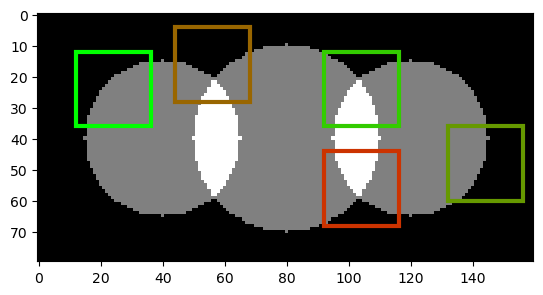

In [30]:
# sketch of some simple test code

#create a synthetic image with some overlapping circles
[yy,xx] = np.mgrid[-40:40,-80:80]
im1 = np.array((xx*xx+yy*yy<=30*30),dtype=float)
[yy,xx] = np.mgrid[-40:40,-40:120]
im2 = np.array((xx*xx+yy*yy<=25*25),dtype=float)
[yy,xx] = np.mgrid[-40:40,-120:40]
im3 = np.array((xx*xx+yy*yy<=25*25),dtype=float)
im = (1/3)*(im1+im2+im3)

#compute feature map with default parameters
fmap = hog(im)

#extract a 3x3 template
template = fmap[2:5,2:5,:]

#run the detect code
detections = detect(im,template,ndetect=5)
    
#visualize results. 
plot_detections(im,detections,(3*8,3*8))

---
# Learning Templates

The final step is to implement a function to learn a template from positive and negative examples. Our code should take a collection of cropped positive and negative examples of the object we are interested in detecting, extract the features for each, and generate a template by taking the average positive template minus the average negative template.

In [31]:
def learn_template(posfiles,negfiles,tsize=np.array([16,16]),bsize=8,norient=9):
    """
    This function takes a list of positive images that contain cropped
    examples of an object + negative files containing cropped background
    and a template size. It produces a HOG template and generates visualization
    of the examples and template
    
    Parameters
    ----------
    posfiles : list of str
         Image files containing cropped positive examples
    
    negfiles : list of str
        Image files containing cropped negative examples

    tsize : (int,int)
        The height and width of the template in blocks
    
    Returns
    -------
    template : float array of size tsize x norient
        The learned HOG template
    
    """           
    
    # compute the template size in pixels 
    # corresponding to the specified template size (given in blocks)
    tsize_pix=bsize*tsize

    # figure to show positive training examples
    fig, ax = plt.subplots(1, 5)
    pltct = 0

    # accumulate average positive and negative templates
    pos_t = np.zeros((tsize[0],tsize[1],norient),dtype=float) 
    for file in posfiles:
        # load in a cropped positive example
        img = plt.imread(file)
        
        # convert to grayscale and resize to fixed dimension tsize_pix
        # using skimage.transform.resize if needed.
        temp_img = (img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114)
        img = temp_img
        img_scaled = ski.transform.resize(img, (tsize[0]*bsize, tsize[1]*bsize))
        
        if pltct < 5:
            ax[pltct].imshow(img_scaled, cmap = plt.cm.gray)
        pltct = pltct + 1
        
        # extract feature
        fmap = hog(img_scaled)
        
        # compute running average
        pos_t += fmap

    pos_t = (1/len(posfiles))*pos_t
    plt.show()
    
    # repeat same process for negative examples
    fig, ax = plt.subplots(1, 5)
    pltct = 0
    neg_t = np.zeros((tsize[0],tsize[1],norient),dtype=float) 
    for file in negfiles:
        img = plt.imread(file)
        temp_img = (img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114)
        img = temp_img
        img_scaled = ski.transform.resize(img, (tsize[0]*bsize, tsize[1]*bsize))
        
        if pltct < 5:
            ax[pltct].imshow(img_scaled, cmap = plt.cm.gray)
        pltct = pltct + 1
        
        # extract feature
        fmap = hog(img_scaled)

        # compute running average
        neg_t += fmap

    neg_t = (1/len(negfiles))*neg_t
    plt.show()

    # add code here to visualize the positive and negative parts of the template
    # using hogvis. you should separately visualize pos_t and neg_t rather than
    # the final tempalte.
    fig3 = plt.figure()
    pos_hog = hogvis(pos_t)
    neg_hog = hogvis(neg_t)
    
    plt.imshow(pos_hog)
    plt.title("Positive Tempalte")
    plt.show()
    plt.title("Negative Tempalte")
    plt.imshow(neg_hog)
    plt.show()

    # now construct our template as the average positive minus average negative
    template = pos_t - neg_t
    template_hog = hogvis(template)
    plt.title("Final Tempalte")
    plt.imshow(template_hog)
    plt.show()

    return template 

---
# Experiments


Test detection by training a template and running it on a test image.

In the experiments should include: (a) a visualization of the positive and negative patches you use to train the template and corresponding hog feature, (b) the detection results on the test image. We should show (a) and (b) for ***two different object categories***.

## Experiment 1: Face detection

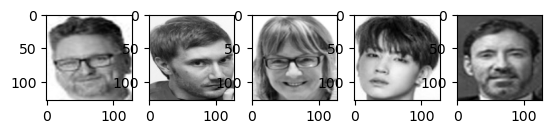

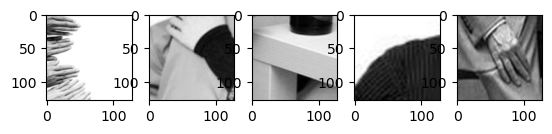

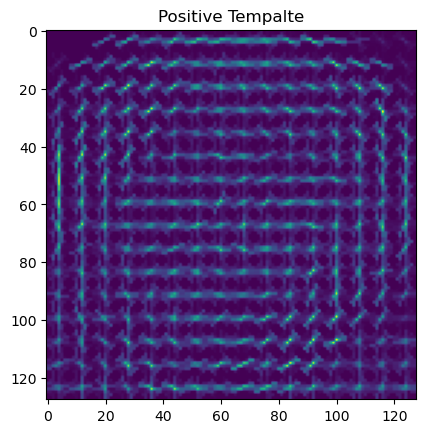

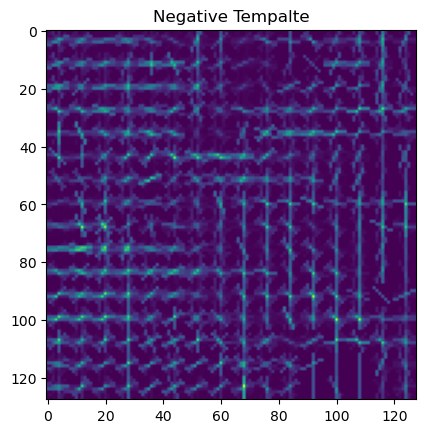

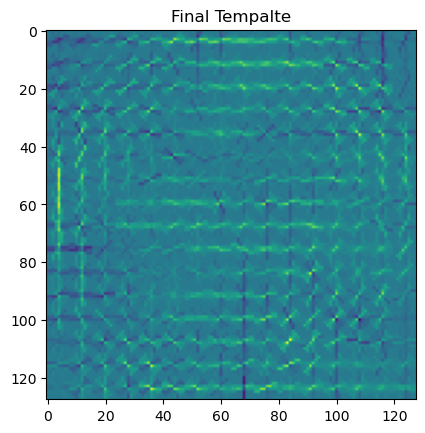

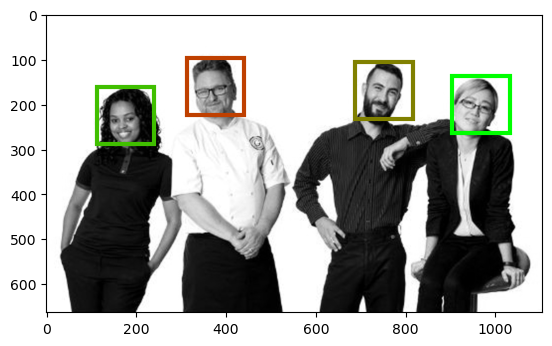

In [32]:
bsize=8
tsize=np.array([16,16])  #height and width in blocks
tsize_pix = bsize*tsize  #height and width in pixels
posfiles = ('pos1.jpg','pos2.jpg','pos3.jpg','pos4.jpg','pos5.jpg', 'pos6.jpg', 'pos7.jpg', 'pos8.jpg')
negfiles = ('neg1.jpg','neg2.jpg','neg3.jpg','neg4.jpg','neg5.jpg')

# call learn_template to learn and visualize the template and training data
template = learn_template(posfiles,negfiles,tsize=tsize)
               
# call detect on one or more test images, visualizing the result with the plot_detections function
img = plt.imread("faces1.jpg")
temp_img = (img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114)
img = temp_img
detections = detect(img,template,ndetect=4)
plot_detections(img,detections,tsize_pix)

## Experiment 2: apple detection

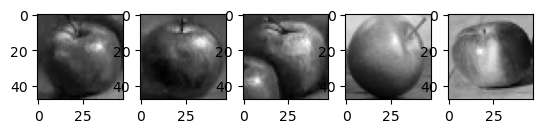

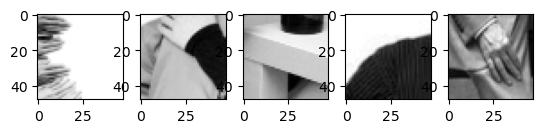

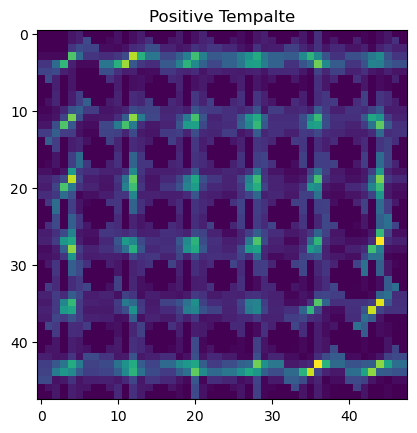

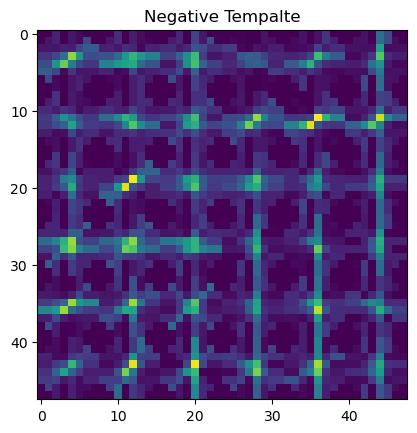

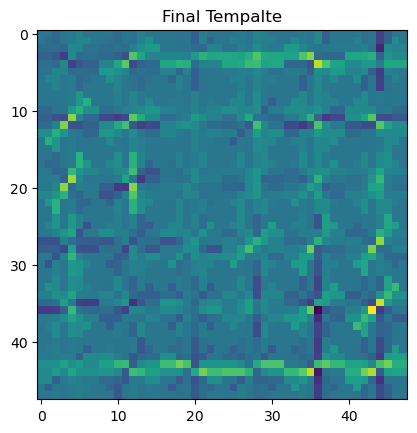

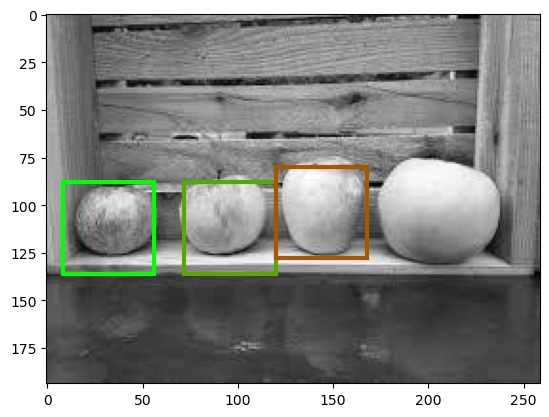

In [33]:
bsize=8
tsize=np.array([6,6])  #height and width in blocks
tsize_pix = bsize*tsize  #height and width in pixels
posfiles = ('app_pos1.jpg','app_pos2.jpg','app_pos3.jpg','app_pos4.jpg','app_pos5.jpg','app_pos6.jpg','app_pos7.jpg','app_pos8.jpg','app_pos9.jpg')
negfiles = ('neg1.jpg','neg2.jpg','neg3.jpg','neg4.jpg','neg5.jpg')
# call learn_template to learn and visualize the template and training data
template = learn_template(posfiles,negfiles,tsize=tsize)
               
# call detect on one or more test images, visualizing the result with the plot_detections function

img = plt.imread("apple11.jpg")
temp_img = (img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114)
img = temp_img
detections = detect(img,template,ndetect=3)
plot_detections(img,detections,tsize_pix)

## Experiment 3: sign detection

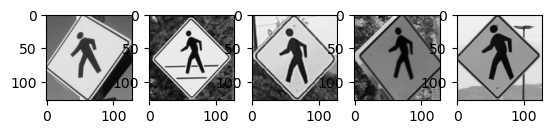

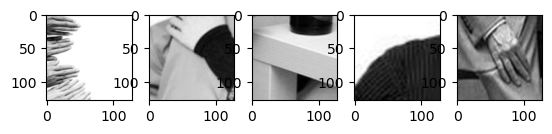

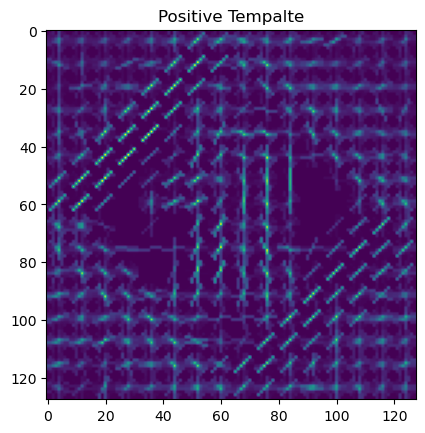

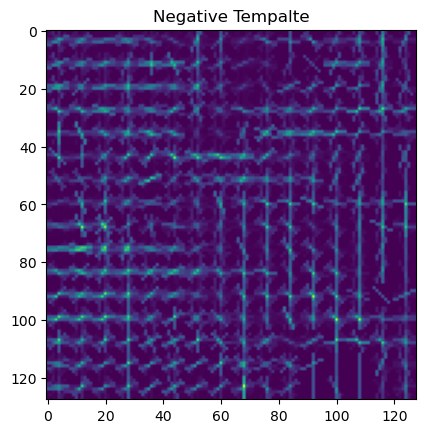

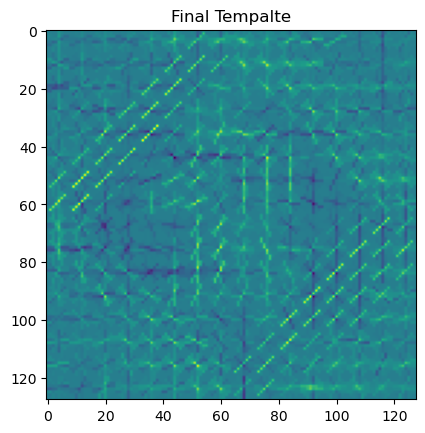

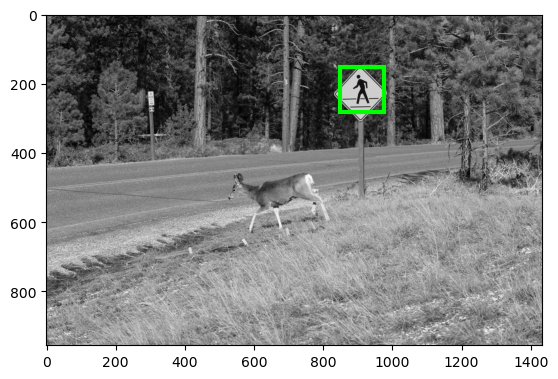

In [34]:
bsize=8
tsize=np.array([16,16])  #height and width in blocks
tsize_pix = bsize*tsize  #height and width in pixels
posfiles = ('pos_sign1.jpg','pos_sign2.jpg','pos_sign3.jpg','pos_sign4.jpg','pos_sign5.jpg','pos_sign6.jpg')
negfiles = ('neg1.jpg','neg2.jpg','neg3.jpg','neg4.jpg','neg5.jpg')
# call learn_template to learn and visualize the template and training data
template = learn_template(posfiles,negfiles,tsize=tsize)
               
# call detect on one or more test images, visualizing the result with the plot_detections function

img = plt.imread("sign2.jpg")
temp_img = (img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114)
img = temp_img
detections = detect(img,template,ndetect=1)
plot_detections(img,detections,tsize_pix)